# Enumerate cultivation errors

In [ ]:
import collections

import stim
from itertools import product
from functools import reduce 

def xor_two_errors(a, b):
    if a[0] is None:
        return b
    if b[0] is None:
        return b
    return a[0]^b[0], [a[1],b[1]] 

def check_product_error(combined_error : list[stim.DemTargetWithCoords]):
    """
    check if the combined error is an undetectable logical error
    """
    if combined_error[0] is None :
        return False
    if all(error.dem_target.is_logical_observable_id() for error in combined_error[0]) and len(combined_error[0]) > 0:
        return True
    return False

In [ ]:
def find_errors_mechanisms(circuit, depth = 1):
    logical_error_terms = []
    dem_error_terms = []
    dem_error_terms.append([(set(i.dem_error_terms),(i.circuit_error_locations)) for i in circuit.explain_detector_error_model_errors()] +[(None,1)])
    options = product(*(dem_error_terms*depth))
    for option in options:
        error_product = reduce(xor_two_errors, option,[set(), 1])
        if check_product_error(error_product):
            logical_error_terms.append([error_product, option])
    return logical_error_terms
 

In [ ]:
cultivation_file = './circuits/c=inject[unitary]+cultivate,p=0.001,noise=uniform,g=css,q=15,b=Y,r=4,d1=3.stim'

noisy_cultivation = stim.Circuit.from_file(cultivation_file)

circuit = noisy_cultivation

In [ ]:
# This should take some time
bad_error_mechanisms = find_errors_mechanisms(circuit, 3)

## Plot which qubits participate the most

In [ ]:
d = collections.defaultdict(list)

for dem_combination in bad_error_mechanisms:
    for dem_syndrome in dem_combination[1]:
        # This loop should run 3 times for each dem_combination
        for error_location in dem_syndrome[1]:
            gate_type = error_location.instruction_targets.gate
            affected_qubits = [target.gate_target.qubit_value for target in error_location.instruction_targets.targets_in_range]
            # print(f"{gate_type=}, {affected_qubits=}")
            [d[gate_type].append(q) for q in affected_qubits]

print(d)

defaultdict(<class 'list'>, {'M': [...


(0.0, 2900.0)

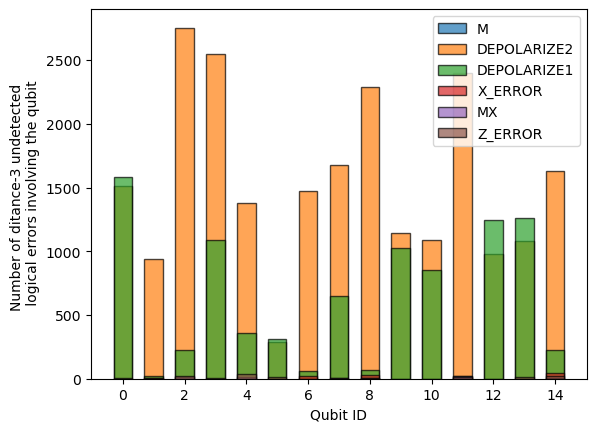

In [ ]:
# plot an histogram of the affected qubits in d['DEPOLARIZE2']
import matplotlib.pyplot as plt

# create histogram centered on the qubit value
for gate_type in d.keys():
    values, counts = np.unique(d[gate_type], return_counts=True)
    plt.bar(values, counts, width=0.6, edgecolor='black', alpha=0.7, label=gate_type)


# plt.hist(d['DEPOLARIZE1'], label='1Q errors')
# plt.hist(d['M'], label='Measurement errors')

plt.legend()
plt.xlabel('Qubit ID')
plt.ylabel('Number of ditance-3 undetected \n logical errors involving the qubit')
plt.ylim(0,2900)

## Flatten the list

Since the above script gives you a list of DEM combinations and not Error combinations, you need to go over the list and extract each error combination.

In [ ]:
fault_mechanisms = []
for dem_combination in bad_error_mechanisms:
    affected_list_list = []
    for dem_syndrome in dem_combination[1]:
        # This loop should run 3 times for each dem_combination
        # print the dem_target of each item in the set
        # print([det.dem_target for det in list(dem_syndrome[0])])
        # print(dem_syndrome[0])
        affected_list = []
        for error_location in dem_syndrome[1]:
            gate_type = error_location.instruction_targets.gate
            affected_qubits = [target.gate_target.qubit_value for target in error_location.instruction_targets.targets_in_range]
            # print(f"{gate_type=}, {affected_qubits=}")
            affected_list.append(affected_qubits)
        affected_list_list.append(affected_list)
    # cross multiply the affected qubit lists
    fault_mechanism = list(product(*affected_list_list))
    # print(fault_mechanism)
    
    fault_mechanisms.extend(fault_mechanism)
    

len(fault_mechanisms)
        

232506

this is how an error mechanism should look like:
([6], [4, 3], [0])

In [ ]:
fault_mechanisms[0]

([6], [4, 3], [0])

# solving as a set hitting problem

In [ ]:
depth = 3
def coverage(fault, immune_qubits: set):
    # return True if the fault is covered by the immune qubits
    return not all([(set(fault[i]) - immune_qubits) for i in range(depth)])

def minimum_set_cover_for_faults(fault_mechanisms, universe=set(range(13))):
    """
    Find a minimum set of qubits that covers the maximum number of fault mechanisms
    
    Args:
        fault_mechanisms: List of fault mechanisms to cover
        universe: The universe of qubit indices (default: 0-12)
        
    Returns:
        A set representing the minimum cover
    """
    # Keep track of the faults we've covered
    covered_faults = set()
    # Our solution set (immune qubits)
    solution = set()
    
    print(f"Starting with {len(covered_faults)}/{len(fault_mechanisms)} faults covered")

    # Keep going until all faults are covered or no more improvement is possible
    while len(covered_faults) < len(fault_mechanisms):
        # Find the qubit that covers the most uncovered faults
        best_qubit = None
        best_coverage_count = 0
        
        for qubit in universe:
            if qubit in solution:
                continue  # Skip if already in our solution
            
            # Temporarily add this qubit to solution to check coverage
            test_solution = solution | {qubit}
            
            # Count how many uncovered faults this qubit would help cover
            coverage_count = 0
            for i, fault in enumerate(fault_mechanisms):
                if i not in covered_faults and coverage(fault, test_solution):
                    coverage_count += 1
            
            if coverage_count > best_coverage_count:
                best_coverage_count = coverage_count
                best_qubit = qubit
        
        if best_qubit is None or best_coverage_count == 0:
            # No more qubits can improve our coverage
            break
            
        # Add this qubit to our solution
        solution.add(best_qubit)
        
        # Update which faults are now covered
        for i, fault in enumerate(fault_mechanisms):
            if i not in covered_faults and coverage(fault, solution):
                covered_faults.add(i)
        
        print(f"Added qubit {best_qubit}, solution={solution}, covered={len(covered_faults)/len(fault_mechanisms)}")
    
    return solution

In [ ]:
minimum_set_cover_for_faults(fault_mechanisms, set(range(circuit.num_qubits)))

Starting with 0/232506 faults covered
Added qubit 0, solution={0}, covered=0.2489742200201285
Added qubit 9, solution={0, 9}, covered=0.41929240535728113
Added qubit 1, solution={0, 9, 1}, covered=0.5729142473742613
Added qubit 8, solution={0, 9, 1, 8}, covered=0.7122396841371835
Added qubit 3, solution={0, 1, 3, 8, 9}, covered=0.8230755335346185
Added qubit 2, solution={0, 1, 2, 3, 8, 9}, covered=0.9571623958091404
Added qubit 4, solution={0, 1, 2, 3, 4, 8, 9}, covered=0.9830714046089133
Added qubit 5, solution={0, 1, 2, 3, 4, 5, 8, 9}, covered=0.998761322288457
Added qubit 12, solution={0, 1, 2, 3, 4, 5, 8, 9, 12}, covered=1.0


{0, 1, 2, 3, 4, 5, 8, 9, 12}

# Solving for hitting problem with 2-qubits each time

In [ ]:
def pair_minimum_set_cover_for_faults(fault_mechanisms, universe=set(range(13))):
    """
    Find a minimum set of qubits that covers the maximum number of fault mechanisms
    Considers pairs of qubits in each iteration
    
    Args:
        fault_mechanisms: List of fault mechanisms to cover
        universe: The universe of qubit indices (default: 0-12)
        
    Returns:
        A set representing the minimum cover
    """
    # Keep track of the faults we've covered
    covered_faults = set()
    # Our solution set (immune qubits)
    solution = set()
    
    print(f"Starting with {len(covered_faults)}/{len(fault_mechanisms)} faults covered")

    # Keep going until all faults are covered or no more improvement is possible
    while len(covered_faults) < len(fault_mechanisms):
        # Find the pair of qubits that covers the most uncovered faults
        best_pair = None
        best_coverage_count = 0
        
        available_qubits = [q for q in universe if q not in solution]
        
        # Try all possible pairs of qubits
        for i in range(len(available_qubits)):
            for j in range(i+1, len(available_qubits)):
                qubit1, qubit2 = available_qubits[i], available_qubits[j]
                
                # Temporarily add this pair to solution to check coverage
                test_solution = solution | {qubit1, qubit2}
                
                # Count how many uncovered faults this pair would help cover
                coverage_count = 0
                for k, fault in enumerate(fault_mechanisms):
                    if k not in covered_faults and coverage(fault, test_solution):
                        # TODO: add weights to the coverage count
                        coverage_count += 1
                
                if coverage_count > best_coverage_count:
                    best_coverage_count = coverage_count
                    best_pair = (qubit1, qubit2)
        
        if best_pair is None or best_coverage_count == 0:
            # No more pairs can improve our coverage
            break
            
        # Add this pair to our solution
        qubit1, qubit2 = best_pair
        solution.add(qubit1)
        solution.add(qubit2)
        
        # Update which faults are now covered
        for i, fault in enumerate(fault_mechanisms):
            if i not in covered_faults and coverage(fault, solution):
                covered_faults.add(i)
        
        print(f"Added pair {best_pair}, solution={solution}, covered={len(covered_faults)}/{len(fault_mechanisms)} ({len(covered_faults)/len(fault_mechanisms):.2%})")
    
    return solution

In [ ]:
pair_minimum_set_cover_for_faults(fault_mechanisms, set(range(circuit.num_qubits)))

Starting with 0/232506 faults covered
Added pair (0, 9), solution={0, 9}, covered=97488/232506 (41.93%)
Added pair (2, 3), solution={0, 9, 2, 3}, covered=171486/232506 (73.76%)
Added pair (1, 8), solution={0, 1, 2, 3, 8, 9}, covered=222546/232506 (95.72%)
Added pair (4, 5), solution={0, 1, 2, 3, 4, 5, 8, 9}, covered=232218/232506 (99.88%)
Added pair (6, 12), solution={0, 1, 2, 3, 4, 5, 6, 8, 9, 12}, covered=232506/232506 (100.00%)


{0, 1, 2, 3, 4, 5, 6, 8, 9, 12}